# このnotebookについて
このnotebookはkaggleにアップロードする用のメインスクリプトである。
データの読み込み、特徴量生成、推論を行う。
本来notebookでなくても良いが、kaggleでの提出が基本的にnotebook形式なのでそれに準じた。

In [1]:
# ライブラリのインポート

import numpy as np
import pandas as pd
import os

from collections import Counter
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Dict, List, Tuple, Any

In [2]:
# グローバル変数の定義
# 各種パスはkaggleアップロード時に適宜変更すること
BATCH_SIZE = 16
MAX_ESM2_TIME = 5

ESM2_MODEL_DIR = "../model/esm2_t12_35M_UR50D"
BERT_MODEL_DIR = "../model/BiomedNLP-BiomedBERT-base-uncased-abstract"

# Embedding save paths
TRAIN_SAVE_PATH = "../output/train_embeddings.pt"
TEST_SAVE_PATH = "../output/test_embeddings.pt"
GO_EMBEDDINGS_SAVE_PATH = "../output/go_embeddings.pt"  # GO埋め込み辞書の保存先

# Model save paths
MODEL_SAVE_PATH = "../output/joint_model.pth"

# Training hyperparameters
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

# Step0: Check the data
This step may be deleted in order to save runtime.

In [3]:
# ==== File paths ====

# Base directory
INPUT_DIR = "../input/cafa-6-protein-function-prediction"

# TSV files
PATH_SAMPLE_SUB   = f"{INPUT_DIR}/sample_submission.tsv"
PATH_IA           = f"{INPUT_DIR}/IA.tsv"
PATH_TEST_TAXON   = f"{INPUT_DIR}/Test/testsuperset-taxon-list.tsv"
PATH_TRAIN_TERMS  = f"{INPUT_DIR}/Train/train_terms.tsv"
PATH_TRAIN_TAXON  = f"{INPUT_DIR}/Train/train_taxonomy.tsv"

# FASTA files
PATH_TEST_FASTA   = f"{INPUT_DIR}/Test/testsuperset.fasta"
PATH_TRAIN_FASTA  = f"{INPUT_DIR}/Train/train_sequences.fasta"

# OBO file
PATH_GO_OBO       = f"{INPUT_DIR}/Train/go-basic.obo"

In [4]:
print("=== sample_submission.tsv ===")

# 列が3つの行も4つの行もあるので、列名をあらかじめ4つ定義しておく
cols = ["protein_id", "kind_or_term", "score", "description"]

sample_df = pd.read_csv(
    PATH_SAMPLE_SUB,
    sep="\t",          # 区切りはタブ
    header=None,       # ファイル先頭行をヘッダとして使わない
    names=cols,        # 自分で列名を指定
    engine="python",   # 行ごとに列数が違っても柔軟に解釈してくれる
)

display(sample_df.head(10))

=== sample_submission.tsv ===


,protein_id,kind_or_term,score,description
0,A0A0C5B5G6,GO:0000001,0.123,None
1,A0A0C5B5G6,GO:0000002,0.456,None
2,A0A0C5B5G6,Text,0.123,Regulates insulin sensitivity and metabolic ho...
3,A0A0C5B5G6,Text,0.456,"Inhibits the folate cycle, thereby reducing de..."
4,A0A0C5B5G6,Text,0.456,and the activation of the metabolic regulator ...
5,A0A1B0GTW7,GO:0000001,0.123,None
6,A0A1B0GTW7,GO:0000002,0.456,None
7,A0A1B0GTW7,Text,0.123,Putative metalloproteinase that plays a role i...
8,A0JNW5,GO:0000001,0.123,None
9,A0JNW5,GO:0000002,0.456,None


In [5]:
print("\n=== IA.tsv ===")
IA_df = pd.read_csv(
    PATH_IA, 
    sep="\t", 
    header=None,
    names=["GO", "weight"]
)
display(IA_df.head())

print("\n=== testsuperset-taxon-list.tsv ===")
test_ID2Species_df = pd.read_csv(PATH_TEST_TAXON, sep="\t")
display(test_ID2Species_df.head())

print("\n=== train_terms.tsv ===")
train_label_df = pd.read_csv(PATH_TRAIN_TERMS, sep="\t")
display(train_label_df.head())

print("\n=== train_taxonomy.tsv ===")
train_Protain2TaxonID_df = pd.read_csv(
    PATH_TRAIN_TAXON, 
    sep="\t", 
    header=None,
    names=["EntryID", "TaxonID"]
)
display(train_Protain2TaxonID_df.head())


=== IA.tsv ===


,GO,weight
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573



=== testsuperset-taxon-list.tsv ===


,ID,Species
0,9606,Homo sapiens
1,10116,Rattus norvegicus
2,39947,Oryza sativa subsp. japonica
3,7955,Danio rerio
4,7227,Drosophila melanogaster



=== train_terms.tsv ===


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P



=== train_taxonomy.tsv ===


,EntryID,TaxonID
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


In [6]:
def preview_fasta(path, max_records=3):
    print(f"=== {path} ===")
    count = 0
    with open(path) as f:
        header = None
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if header is not None:
                    print(header)
                    print(seq[:80], "\n")
                    count += 1
                    if count >= max_records:
                        break
                header = line
                seq = ""
            else:
                seq += line

        if count < max_records and header:
            print(header)
            print(seq[:80], "\n")
preview_fasta(PATH_TRAIN_FASTA)
preview_fasta(PATH_TEST_FASTA)

=== ../input/cafa-6-protein-function-prediction/Train/train_sequences.fasta ===
>sp|A0A0C5B5G6|MOTSC_HUMAN Mitochondrial-derived peptide MOTS-c OS=Homo sapiens OX=9606 GN=MT-RNR1 PE=1 SV=1
MRWQEMGYIFYPRKLR 

>sp|A0JNW5|BLT3B_HUMAN Bridge-like lipid transfer protein family member 3B OS=Homo sapiens OX=9606 GN=BLTP3B PE=1 SV=2
MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPTWLAINKVFCNKASIRIPWTKLKTHPI 

>sp|A0JP26|POTB3_HUMAN POTE ankyrin domain family member B3 OS=Homo sapiens OX=9606 GN=POTEB3 PE=1 SV=2
MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFMKTLRSKMGKCCHHCFPCCRGSGTSNV 

=== ../input/cafa-6-protein-function-prediction/Test/testsuperset.fasta ===
>A0A0C5B5G6 9606
MRWQEMGYIFYPRKLR 

>A0A1B0GTW7 9606
MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKSRSSSLTLPSSRDPQPLRIQSCYLGDHISDGAWDP 

>A0JNW5 9606
MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPTWLAINKVFCNKASIRIPWTKLKTHPI 



In [7]:
def load_fasta(path, mode, max_aa_len=1024):
    print(f"=== {path} ===")
    protainID_to_sequence = {}
    
    with open(path) as f:
        protain_info = None
        seq = ""
        
        for line in f:
            line = line.strip()
            
            if line.startswith(">"):
                # 新しい>から始まる行が登場したら、
                # それまでのpritain_id, taxon_id, seqをprotainID_to_sequenceに記録
                # そしてseqをリセット
                if protain_info is not None:
                    # max_aa_lenより大きい場合はカット
                    if len(seq) <= max_aa_len:
                        seq = seq[:max_aa_len]
                    protainID_to_sequence[protain_info] = seq
                    seq = ""

                # trainとtestで微妙に形式が違うので場合分け
                # 正規表現で取り出した方がいいかも
                if mode == "train":
                    protain_id = line.split("|")[1]
                    taxon_id = line.split("OX=")[1].split()[0]
                elif mode == "test":
                    protain_id, taxon_id = line.split()
                    protain_id = protain_id[1:]
                    
                protain_info = (protain_id, taxon_id)
            else:
                seq += line
                
    return protainID_to_sequence
                
train_IDs_to_Seq = load_fasta(path=PATH_TRAIN_FASTA, mode="train")
test_IDs_to_Seq = load_fasta(path=PATH_TEST_FASTA, mode="test")

=== ../input/cafa-6-protein-function-prediction/Train/train_sequences.fasta ===
=== ../input/cafa-6-protein-function-prediction/Test/testsuperset.fasta ===


In [8]:
count = 0
for k, v in train_IDs_to_Seq.items():
    print(f"protain_info: {k}")
    print(f"seq_head: {v[:20]}")
    count += 1

    if count == 3:
        break

protain_info: ('A0A0C5B5G6', '9606')
seq_head: MRWQEMGYIFYPRKLR
protain_info: ('A0JNW5', '9606')
seq_head: MAGIIKKQILKHLSRFTKNL
protain_info: ('A0JP26', '9606')
seq_head: MVAEVCSMPAASAVKKPFDL


In [9]:
count = 0
for k, v in test_IDs_to_Seq.items():
    print(f"protain_info: {k}")
    print(f"seq_head: {v[:20]}")
    count += 1

    if count == 3:
        break

protain_info: ('A0A0C5B5G6', '9606')
seq_head: MRWQEMGYIFYPRKLR
protain_info: ('A0A1B0GTW7', '9606')
seq_head: MLLLLLLLLLLPPLVLRVAA
protain_info: ('A0JNW5', '9606')
seq_head: MAGIIKKQILKHLSRFTKNL


配列本数 (N): 82403
最小長: 3
最大長: 35213
平均長: 525.79
中央値: 409.00
25% 分位: 250.00
50% 分位: 409.00
75% 分位: 630.00
90% 分位: 989.00
95% 分位: 1318.00
99% 分位: 2375.00
長さ10000を超える配列の数: 8


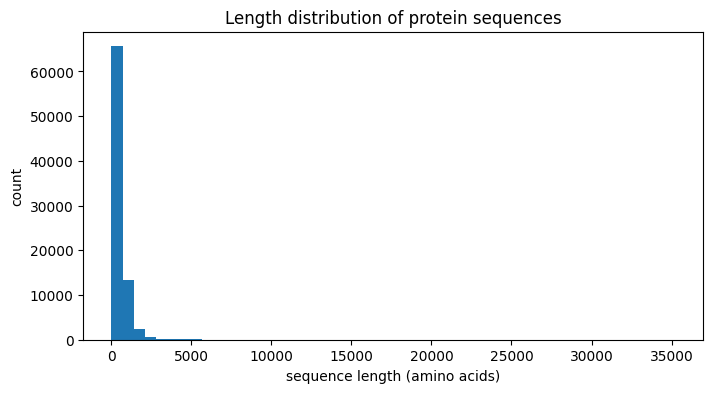

In [10]:
# アミノ酸配列の長さの分布を確認
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 前提:
#   sequences: アミノ酸配列のリスト
#   例: ["MKTLLI...", "AAAA...", ...]  # 長さ 82403 を想定
# ============================================
# ０) sequenceだけのリスト用意
train_sequences = list(train_IDs_to_Seq.values())
test_sequences = list(test_IDs_to_Seq.values())

# 1) 各配列の長さを計算
lengths = [len(seq) for seq in train_sequences]

print(f"配列本数 (N): {len(lengths)}")
print(f"最小長: {min(lengths)}")
print(f"最大長: {max(lengths)}")
print(f"平均長: {np.mean(lengths):.2f}")
print(f"中央値: {np.median(lengths):.2f}")

# 分位点も見てみる（25%, 50%, 75%）
for q in [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"{int(q*100)}% 分位: {np.quantile(lengths, q):.2f}")

# 長さ10000を超える配列の数
over_10000_lengths = [length for length in lengths if length >= 10000]
print(f"長さ10000を超える配列の数: {len(over_10000_lengths)}")

# 2) 長さごとの本数を集計（分布を見る
length_counter = Counter(lengths)


# 3) ヒストグラムを描いてみる（ざっくり分布を確認）
plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=50)  # ビン数はお好みで調整
plt.xlabel("sequence length (amino acids)")
plt.ylabel("count")
plt.title("Length distribution of protein sequences")
plt.show()


In [11]:
from pathlib import Path
from typing import Dict, List, Tuple, Any

def parse_go_obo(filepath: str) -> Tuple[Dict[str, List[str]], Dict[str, Dict[str, Any]]]:
    """
    go-basic.obo ファイルを読み込んで、ヘッダー情報と Term 情報をパースする関数。

    Parameters
    ----------
    filepath : str
        読み込む go-basic.obo ファイルのパス

    Returns
    -------
    meta : Dict[str, List[str]]
        ファイル先頭部分（[Term] より前）のメタデータ。
        キー: "format-version" や "subsetdef" などの項目名
        値  : その行の値を格納した文字列のリスト
              （同じキーが複数回出てくることがあるのでリスト）

    terms : Dict[str, Dict[str, Any]]
        GO term を格納した辞書。
        キー: "GO:0000001" のような id
        値  : その term の情報をまとめた辞書。例:
              {
                  "id": "GO:0000001",
                  "name": "mitochondrion inheritance",
                  "namespace": "biological_process",
                  "def": "...",
                  "alt_id": [...],
                  "synonym": [...],
                  "is_a": [...],
                  "is_obsolete": False,
                  "replaced_by": [...],
                  "raw": {元の key: value を全部入れた辞書}
              }
    """
    path = Path(filepath)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {filepath}")

    # ヘッダー部分を入れる辞書
    meta: Dict[str, List[str]] = {}

    # Term を id -> term_dict の形で入れる辞書
    terms: Dict[str, Dict[str, Any]] = {}

    # 現在読み取り中の term（[Term] ブロック）の情報を一時的に格納する変数
    current_term: Dict[str, Any] | None = None

    # まだ [Term] に入っていないヘッダー行を読んでいるかどうか
    in_header = True

    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")

            # コメント行（! で始まる）はスキップ
            if line.startswith("!"):
                continue

            # 空行は「ブロックの区切り」を意味する
            if not line.strip():
                # [Term] ブロックの終端だった場合、現在の term を保存する
                if current_term is not None and "id" in current_term and current_term["id"]:
                    term_id = current_term["id"]
                    terms[term_id] = current_term
                    current_term = None
                continue

            # [Term] という行が来たら、新しい term ブロックの開始
            if line == "[Term]":
                in_header = False  # ここから先はヘッダーではない
                # 今までの current_term が残っていたら保存（EOF直前の空行がないケースの保険）
                if current_term is not None and "id" in current_term and current_term["id"]:
                    term_id = current_term["id"]
                    terms[term_id] = current_term
                # 新しい term 用の辞書を初期化
                current_term = {
                    "id": None,
                    "name": None,
                    "namespace": None,
                    "def": None,
                    "alt_id": [],
                    "synonym": [],
                    "is_a": [],
                    "is_obsolete": False,
                    "replaced_by": [],
                    # すべての key: value をそのまま保持しておきたい場合
                    "raw": {}
                }
                continue

            # ここから下は「key: value」形式の行を処理する
            if ":" not in line:
                # 想定外の行はそのまま無視してよい（必要ならログ出力など）
                continue

            key, value = line.split(":", 1)
            key = key.strip()
            value = value.strip()

            if in_header:
                # ヘッダー部分 -> meta に格納
                meta.setdefault(key, []).append(value)
            else:
                # Term ブロックの中 -> current_term を更新
                if current_term is None:
                    # ありえないが、安全のため
                    continue

                # 「生の key:value も残しておきたい」場合
                current_term["raw"].setdefault(key, []).append(value)

                if key == "id":
                    current_term["id"] = value
                elif key == "name":
                    current_term["name"] = value
                elif key == "namespace":
                    current_term["namespace"] = value
                elif key == "def":
                    current_term["def"] = value
                elif key == "alt_id":
                    current_term["alt_id"].append(value)
                elif key == "synonym":
                    current_term["synonym"].append(value)
                elif key == "is_a":
                    current_term["is_a"].append(value)
                elif key == "is_obsolete":
                    # "true" / "false" が来るので bool に変換
                    current_term["is_obsolete"] = value.lower() == "true"
                elif key == "replaced_by":
                    current_term["replaced_by"].append(value)
                else:
                    # その他の key（comment, relationship など）は必要に応じて later use
                    # ここでは raw にだけ入れておく
                    pass

    # ファイルが空行で終わっていない場合、最後の term を保存
    if current_term is not None and "id" in current_term and current_term["id"]:
        term_id = current_term["id"]
        terms[term_id] = current_term

    return meta, terms


In [12]:
meta, terms = parse_go_obo(PATH_GO_OBO)

print("meta exmple")
for k, v in meta.items():
    print(f"k: {k}")
    print(f"v: {v}")
    break

print("========================================================================================")

print("terms example")
for k, v in terms.items():
    print(f"k: {k}")
    print(f"v: {v}")
    break

meta exmple
k: format-version
v: ['1.2']
terms example
k: GO:0000001
v: {'id': 'GO:0000001', 'name': 'mitochondrion inheritance', 'namespace': 'biological_process', 'def': '"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton." [GOC:mcc, PMID:10873824, PMID:11389764]', 'alt_id': [], 'synonym': ['"mitochondrial inheritance" EXACT []'], 'is_a': ['GO:0048308 ! organelle inheritance', 'GO:0048311 ! mitochondrion distribution'], 'is_obsolete': False, 'replaced_by': [], 'raw': {'id': ['GO:0000001'], 'name': ['mitochondrion inheritance'], 'namespace': ['biological_process'], 'def': ['"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton." [GOC:mcc, PMID:10873824, PMID:11389764]'], 'synonym': ['"mitochondrial inheritance" EXACT []'], 'is

# Step1: Convert amino acid seaquence to vector

## Step1-1: load esm2 model

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel
esm2_tokenizer = AutoTokenizer.from_pretrained(ESM2_MODEL_DIR, do_lower_case=False)
esm2_model = AutoModel.from_pretrained(ESM2_MODEL_DIR)

/Users/rmisaka/WorkSpace/Kaggle_CAFA6/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmModel were not initialized from the model checkpoint at ../model/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import torch

# GPUが使えるかどうか確認
# kaggleではmps->cudaに変更すること
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

# モデルをGPUまたはCPUに移動
esm2_model = esm2_model.to(device)

# 学習ではなく推論なので eval() にしておく（dropoutなどをオフ）
esm2_model.eval()

device: mps


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 480, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-11): 12 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=480, out_features=480, bias=True)
            (key): Linear(in_features=480, out_features=480, bias=True)
            (value): Linear(in_features=480, out_features=480, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=480, out_features=1920, bias=True)
        )
        (output): EsmOutput(
      

## Step1-2: predict amino acid vector

In [15]:
from typing import Dict, Tuple, List


def make_batches_from_seq_dict(
    seq_dict: Dict[Tuple[str, str], str],
    batch_size: int
) -> List[List[Tuple[Tuple[str, str], str]]]:
    """
    説明:
        {(protein_id, taxon_id): seq} 形式の辞書を、
        指定したバッチサイズごとに分割する関数です。

    引数:
        seq_dict:
            キー: (protein_id, taxon_id)
            値:   アミノ酸配列文字列
        batch_size:
            1バッチに含める最大件数。

    戻り値:
        batches:
            各要素が「バッチ」のリスト。
            各バッチは [((protein_id, taxon_id), seq), ...] という形のリスト。
    
    使用例:
        seq_dict = {("P12345", "9606"): "MKT...", ("Q8ABC9", "10090"): "AAA..."}
        batches = make_batches_from_seq_dict(seq_dict, batch_size=256)
    """
    items = list(seq_dict.items())  # [ ((protein_id, taxon_id), seq), ... ]
    batches: List[List[Tuple[Tuple[str, str], str]]] = []

    for i in range(0, len(items), batch_size):
        batch = items[i:i + batch_size]
        batches.append(batch)

    return batches

In [16]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from typing import Any
import time

def encode_batch_with_esm(
    batch: List[Tuple[Tuple[str, str], str]],
    tokenizer: AutoTokenizer,
    model: AutoModel,
    device: torch.device,
    max_aa_len: int = 1024
) -> List[Tuple[Tuple[str, str], np.ndarray]]:
    """
    説明:
        1バッチ分の [( (protein_id, taxon_id), seq ), ...] を入力として、
        各配列を ESM-2 でベクトル化し、
        [ ( (protein_id, taxon_id), embedding ), ... ] を返す関数です。

        各配列について:
          - tokenizer で padding / truncation / special token 付与
          - model から hidden_states (B, L, D) を取得
          - attention_mask から実長 true_len を求める
          - [CLS] と [EOS] を除いたトークンを mean pooling して 1ベクトル(D,) にする

    引数:
        batch:
            1バッチ分のリスト。
            各要素は ((protein_id, taxon_id), seq)。
        tokenizer:
            ESM-2 用トークナイザ。
        model:
            ESM-2 モデル本体。
        device:
            使用するデバイス (cuda / cpu)。

    戻り値:
        result_list:
            [ ( (protein_id, taxon_id), embedding ), ... ] のリスト。
            embedding は numpy.ndarray で shape = (D,)。
    """
    # ID と配列を別リストに分解
    id_list = [item[0] for item in batch]   # [(protein_id, taxon_id), ...]
    seq_list = [item[1] for item in batch]  # ["MKT...", "AAA...", ...]

    # 1) tokenizer でトークナイズ + padding
    inputs = tokenizer(
        seq_list,
        return_tensors="pt",
        padding=True,        # バッチ内の最長長さに合わせて padding
        truncation=True,     # モデルの最大長を超える場合は切り捨て
        max_length=max_aa_len + 2,
        add_special_tokens=True
    )

    # 2) device に載せる
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3) モデルで hidden states を計算
    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states: torch.Tensor = outputs.last_hidden_state  # (B, L, D)
    attention_mask: torch.Tensor = inputs["attention_mask"]  # (B, L)

    batch_size = hidden_states.size(0)
    result_list: List[Tuple[Tuple[str, str], np.ndarray]] = []

    for i in range(batch_size):
        seq_id = id_list[i]          # (protein_id, taxon_id)
        mask_i = attention_mask[i]   # (L,)
        hs_i = hidden_states[i]      # (L, D)

        # 有効トークン数（CLS/EOS 含む）
        true_len = mask_i.sum().item()

        # 通常は [CLS] と [EOS] を除いた [1 : true_len-1] を使う
        if true_len > 2:
            token_vecs = hs_i[1:true_len - 1, :]  # (L_true-2, D)
        else:
            # 極端に短い場合の保険
            token_vecs = hs_i[:true_len, :]

        # mean pooling で 1 ベクトルに集約
        protein_vec = token_vecs.mean(dim=0)          # (D,)
        protein_vec_np = protein_vec.cpu().numpy() # numpy に変換

        result_list.append((seq_id, protein_vec_np))

    return result_list

In [17]:
from typing import Dict


def encode_all_sequences_with_esm(
    seq_dict: Dict[Tuple[str, str], str],
    tokenizer: AutoTokenizer,
    model: AutoModel,
    device: torch.device,
    batch_size: int = 64
) -> Dict[Tuple[str, str], np.ndarray]:
    """
    説明:
        {(protein_id, taxon_id): seq} 形式の辞書を入力として、
        ESM-2 で全配列をベクトル化し、
        {(protein_id, taxon_id): embedding} の辞書を返す高レベル関数です。

        内部では:
          - make_batches_from_seq_dict でバッチに分割
          - encode_batch_with_esm で各バッチを処理
          - 結果を1つの辞書にまとめる

    引数:
        seq_dict:
            {(protein_id, taxon_id): seq} 形式の辞書。
        tokenizer:
            ESM-2 用トークナイザ。
        model:
            ESM-2 モデル本体。
        device:
            使用するデバイス。
        batch_size:
            1バッチあたりの件数。GPUメモリに応じて調整。

    戻り値:
        emb_dict:
            {(protein_id, taxon_id): embedding} 形式の辞書。
            embedding は numpy.ndarray (D,)。
    """
    batches = make_batches_from_seq_dict(seq_dict, batch_size=batch_size)
    emb_dict: Dict[Tuple[str, str], np.ndarray] = {}

    model.eval()

    for batch in batches:
        batch_results = encode_batch_with_esm(batch, tokenizer, model, device)
        for seq_id, emb in batch_results:
            emb_dict[seq_id] = emb

        # 一時変数を消してキャッシュを捨てる
        del batch_results
        torch.cuda.empty_cache()

    return emb_dict

In [18]:
# mini_batchで動作検証
from itertools import islice

# train_IDs_to_Seqから先頭BATCH_SIZE個だけ抽出
mini_IDs_to_Seq = dict(islice(train_IDs_to_Seq.items(), 0, BATCH_SIZE+1))

In [19]:
# mini_batch作成 かつ 実行時間測定
import time
start = time.perf_counter()

mini_emb_dict = encode_all_sequences_with_esm(
    seq_dict=mini_IDs_to_Seq,
    tokenizer=esm2_tokenizer,
    model=esm2_model,
    device=device,
    batch_size=BATCH_SIZE
)

end = time.perf_counter()

In [20]:
# 全体の実行時間推定
# 予測実行時間が想定実行時間を超えていた場合エラー発生
ex_time_per_batch = end - start
print(f"実行時間: {ex_time_per_batch}")

whole_ex_time = (len(train_IDs_to_Seq) + len(test_IDs_to_Seq)) / BATCH_SIZE * ex_time_per_batch / 3600
print(f"whole_ex_time is {whole_ex_time} hours")


# 
print(f"想定実行時間: {MAX_ESM2_TIME}")
print(f"予測実行時間: {whole_ex_time}")
if whole_ex_time >= MAX_ESM2_TIME:
    raise RuntimeError(f"予測実行時間が想定実行時間を超えています")

実行時間: 3.594720666005742
whole_ex_time is 19.141325871376512 hours
想定実行時間: 5
予測実行時間: 19.141325871376512


RuntimeError: 予測実行時間が想定実行時間を超えています

In [21]:
"""
train_emb_dict = encode_all_sequences_with_esm(
    seq_dict=train_IDs_to_Seq,
    tokenizer=tokenizer,
    model=model,
    device=device,
    batch_size=16
)
"""

'\ntrain_emb_dict = encode_all_sequences_with_esm(\n    seq_dict=train_IDs_to_Seq,\n    tokenizer=tokenizer,\n    model=model,\n    device=device,\n    batch_size=16\n)\n'

In [22]:
"""
test_emb_dict = encode_all_sequences_with_esm(
    seq_dict=test_IDs_to_Seq,
    tokenizer=tokenizer,
    model=model,
    device=device,
    batch_size=16
)
"""

'\ntest_emb_dict = encode_all_sequences_with_esm(\n    seq_dict=test_IDs_to_Seq,\n    tokenizer=tokenizer,\n    model=model,\n    device=device,\n    batch_size=16\n)\n'

## step1-3: save amimno acid vectors

In [23]:
import torch
from pathlib import Path
from typing import Dict, Tuple, Any

def save_emb_dict(emb_dict: Dict[Tuple[str, int], Any], filepath: str) -> None:
    """
    emb_dict をファイルに保存する関数

    Parameters
    ----------
    emb_dict : Dict[Tuple[str, int], Any]
        キーが (protein_id, taxon_id)、値が埋め込みベクトル
        （torch.Tensor や numpy.ndarray）である辞書。
    filepath : str
        保存先ファイルパス。
        例: "embeddings.pt" や "/kaggle/working/embeddings.pt"

    Returns
    -------
    None
        返り値はありません。指定パスにファイルが作成されます。
    """
    path = Path(filepath)

    # GPU 上の Tensor が含まれていた場合に備えて CPU に移しておく
    cpu_dict = {}
    for key, value in emb_dict.items():
        # torch.Tensor なら .cpu() で CPU 転送
        if isinstance(value, torch.Tensor):
            cpu_dict[key] = value.cpu()
        else:
            # numpy.ndarray などはそのまま入れてOK
            cpu_dict[key] = value

    # torch.save は Python の任意オブジェクトを保存できる
    torch.save(cpu_dict, path)


def load_emb_dict(filepath: str, map_location: str = "cpu") -> Dict[Tuple[str, int], Any]:
    """
    保存しておいた emb_dict を読み込む関数

    Parameters
    ----------
    filepath : str
        読み込むファイルのパス。
        例: "embeddings.pt" や "/kaggle/working/embeddings.pt"
    map_location : str, default "cpu"
        torch.load の map_location 引数。
        GPU 環境で「最初から GPU に載せたい」場合は "cuda" などを指定。

    Returns
    -------
    Dict[Tuple[str, int], Any]
        保存されていた emb_dict と同じ形式の辞書。
    """
    path = Path(filepath)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {filepath}")

    emb_dict = torch.load(path, map_location=map_location, weights_only=False)
    return emb_dict

In [24]:
def save_go_embeddings(
    go_embeddings_dict: Dict[str, np.ndarray],
    filepath: str
) -> None:
    """
    GO埋め込み辞書をファイルに保存する関数
    
    Parameters
    ----------
    go_embeddings_dict : Dict[str, np.ndarray]
        GO ID -> 埋め込みベクトルの辞書
    filepath : str
        保存先ファイルパス
    """
    path = Path(filepath)
    torch.save(go_embeddings_dict, path)
    print(f"GO embeddings saved to {filepath}")


def load_go_embeddings(filepath: str) -> Dict[str, np.ndarray]:
    """
    保存したGO埋め込み辞書を読み込む関数
    
    Parameters
    ----------
    filepath : str
        読み込むファイルのパス
        
    Returns
    -------
    Dict[str, np.ndarray]
        GO ID -> 埋め込みベクトルの辞書
    """
    path = Path(filepath)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    go_embeddings_dict = torch.load(path, map_location="cpu", weights_only=False)
    print(f"GO embeddings loaded from {filepath}")
    print(f"Number of GO terms: {len(go_embeddings_dict)}")
    
    return go_embeddings_dict


def reconstruct_go_matrix_from_dict(
    go_embeddings_dict: Dict[str, np.ndarray]
) -> Tuple[torch.Tensor, List[str]]:
    """
    GO埋め込み辞書から行列とIDリストを再構築する関数
    
    Parameters
    ----------
    go_embeddings_dict : Dict[str, np.ndarray]
        GO ID -> 埋め込みベクトルの辞書
        
    Returns
    -------
    go_emb_matrix : torch.Tensor
        shape = (num_go, hidden_dim) のGO埋め込み行列
    go_id_list : List[str]
        各行に対応するGO IDのリスト（ソート済み）
    """
    # ソートされた順序でIDリストを作成（再現性のため）
    go_id_list = sorted(go_embeddings_dict.keys())
    
    # 行列を構築
    go_emb_matrix = torch.from_numpy(
        np.stack([go_embeddings_dict[go_id] for go_id in go_id_list], axis=0)
    ).float()
    
    return go_emb_matrix, go_id_list

In [25]:
# save_emb_dict(train_emb_dict, TRAIN_SAVE_PATH)
# save_emb_dict(test_emb_dict, TEST_SAVE_PATH)

In [26]:
mini_save_path = "../output/mini_embeddings.pt"
save_emb_dict(mini_emb_dict, mini_save_path)

In [27]:
mini_emb_dict = load_emb_dict(mini_save_path)

for k, v in mini_emb_dict.items():
    print(f"seq: {k}")
    print(f"type emb: {type(v)}")
    print(f"emb shape: {v.shape}")

    break

seq: ('A0A0C5B5G6', '9606')
type emb: <class 'numpy.ndarray'>
emb shape: (480,)


# Step 3: convert GO to embedding vector

In [28]:
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_DIR)
bert_model = AutoModel.from_pretrained(BERT_MODEL_DIR)

# モデルをデバイスに移動
bert_model = bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [29]:
def embed_go_text(text: str, tokenizer: AutoTokenizer, model: AutoModel, device: torch.device) -> np.ndarray:
    """
    BiomedBERT を使って、文字列をベクトルに変換する関数。
    出力は shape = (hidden_dim,) の1つのベクトル。

    標準的には CLS ベクトル（文頭トークン）を使う。
    
    Parameters
    ----------
    text : str
        埋め込みたいテキスト（GO termの名前や定義など）
    tokenizer : AutoTokenizer
        BiomedBERT用のトークナイザ
    model : AutoModel
        BiomedBERTモデル
    device : torch.device
        使用するデバイス
        
    Returns
    -------
    np.ndarray
        shape = (hidden_dim,) のベクトル
    """
    # 1. テキストをモデル入力に変換（tokenize）
    tokens = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=256,
    )
    
    # 2. デバイスに移動
    tokens = {k: v.to(device) for k, v in tokens.items()}

    # 3. モデルに通す
    with torch.no_grad():
        output = model(**tokens)

    # 4. CLS トークンの出力を取り出す（文全体の意味）
    cls_vector = output.last_hidden_state[:, 0, :]   # shape = (1, hidden_dim)

    # 5. shape を (hidden_dim,) に変えてnumpyに変換
    return cls_vector.squeeze(0).cpu().numpy()

# Step4: Create DataLoader for training

In [30]:
def create_go_embedding_matrix(
    terms: Dict[str, Dict[str, Any]],
    train_label_df: pd.DataFrame,
    tokenizer: AutoTokenizer,
    model: AutoModel,
    device: torch.device
) -> Tuple[torch.Tensor, List[str], Dict[str, np.ndarray]]:
    """
    学習データに登場するGO termの埋め込み行列を作成する関数
    
    Parameters
    ----------
    terms : Dict[str, Dict[str, Any]]
        parse_go_obo関数で取得したGO term辞書
    train_label_df : pd.DataFrame
        train_terms.tsv から読み込んだDataFrame
    tokenizer : AutoTokenizer
        BiomedBERT用のトークナイザ
    model : AutoModel
        BiomedBERTモデル
    device : torch.device
        使用するデバイス
        
    Returns
    -------
    go_emb_matrix : torch.Tensor
        shape = (num_go, hidden_dim) のGO埋め込み行列
        行の順序は go_id_list と一致（ソート済み）
    go_id_list : List[str]
        各行に対応するGO IDのリスト（ソート済み）
    go_embeddings_dict : Dict[str, np.ndarray]
        GO ID -> 埋め込みベクトルの辞書
        これを保持することで、順序に依存しない安全な管理が可能
    """
    # 1. 学習データに登場するユニークなGO termを取得
    unique_go_terms = train_label_df['term'].unique().tolist()
    print(f"Number of unique GO terms in training data: {len(unique_go_terms)}")
    
    # 2. 各GO termの埋め込みを辞書として計算
    go_embeddings_dict: Dict[str, np.ndarray] = {}
    
    for go_id in unique_go_terms:
        if go_id in terms:
            # GO termの名前と定義を結合してテキスト化
            term_info = terms[go_id]
            name = term_info.get('name', '')
            definition = term_info.get('def', '')
            
            # 定義から引用符とリファレンスを除去
            if definition:
                # "..." [ref] 形式から "..." 部分だけ取り出す
                definition = definition.split('[')[0].strip().strip('"')
            
            # 名前と定義を結合
            text = f"{name}. {definition}" if definition else name
            
            # 埋め込みを計算して辞書に格納
            emb = embed_go_text(text, tokenizer, model, device)
            go_embeddings_dict[go_id] = emb
        else:
            print(f"Warning: GO term {go_id} not found in go-basic.obo")
    
    # 3. モデル用に確定的な順序でソート
    #    ソートすることで、常に同じ順序が保証される（再現性）
    go_id_list = sorted(go_embeddings_dict.keys())
    
    # 4. ソートされた順序で行列を構築
    go_emb_matrix = torch.from_numpy(
        np.stack([go_embeddings_dict[go_id] for go_id in go_id_list], axis=0)
    ).float()
    
    print(f"GO embedding matrix shape: {go_emb_matrix.shape}")
    print(f"GO IDs are sorted alphabetically for reproducibility")
    
    return go_emb_matrix, go_id_list, go_embeddings_dict

In [31]:
from torch.utils.data import Dataset, DataLoader

class ProteinGODataset(Dataset):
    """
    タンパク質埋め込みとGOラベルのデータセット
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Parameters
        ----------
        X : np.ndarray
            shape = (num_samples, protein_emb_dim)
            タンパク質埋め込み
        y : np.ndarray
            shape = (num_samples, num_go_terms)
            マルチラベル行列
        """
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'x': self.X[idx],  # (protein_emb_dim,)
            'y': self.y[idx]   # (num_go_terms,)
        }

In [32]:
def create_protein_go_label_matrix(
    protein_emb_dict: Dict[Tuple[str, str], np.ndarray],
    train_label_df: pd.DataFrame,
    go_id_list: List[str]
) -> Tuple[np.ndarray, np.ndarray, List[Tuple[str, str]]]:
    """
    タンパク質埋め込みとGOラベルの対応行列を作成する関数
    
    Parameters
    ----------
    protein_emb_dict : Dict[Tuple[str, str], np.ndarray]
        {(protein_id, taxon_id): embedding} 形式の辞書
    train_label_df : pd.DataFrame
        train_terms.tsv から読み込んだDataFrame
        columns: ['EntryID', 'term', 'aspect']
    go_id_list : List[str]
        GO IDのリスト（ソート済み）
        go_raw_emb_matrix の行と対応
        
    Returns
    -------
    X : np.ndarray
        shape = (num_proteins, protein_emb_dim)
        タンパク質埋め込み行列
    y : np.ndarray
        shape = (num_proteins, num_go_terms)
        マルチラベル行列（0 or 1）
    protein_ids : List[Tuple[str, str]]
        各行に対応する (protein_id, taxon_id) のリスト
    """
    # 1. GO ID -> インデックスのマッピングを作成
    go_id_to_idx = {go_id: idx for idx, go_id in enumerate(go_id_list)}
    num_go = len(go_id_list)
    
    # 2. EntryID -> GO terms のマッピングを作成
    protein_to_go_terms = {}
    for _, row in train_label_df.iterrows():
        entry_id = row['EntryID']
        go_term = row['term']
        
        if entry_id not in protein_to_go_terms:
            protein_to_go_terms[entry_id] = []
        
        # go_id_listに含まれるGO termのみ追加
        if go_term in go_id_to_idx:
            protein_to_go_terms[entry_id].append(go_term)
    
    # 3. protein_emb_dict から訓練データを構築
    #    ラベル情報があるタンパク質のみを使用
    X_list = []
    y_list = []
    protein_ids = []
    
    for (protein_id, taxon_id), emb in protein_emb_dict.items():
        # このタンパク質のラベルが存在するかチェック
        if protein_id in protein_to_go_terms:
            # 埋め込みベクトルを追加
            X_list.append(emb)
            
            # マルチラベルベクトルを作成（全GO termに対して0/1）
            label_vec = np.zeros(num_go, dtype=np.float32)
            for go_term in protein_to_go_terms[protein_id]:
                idx = go_id_to_idx[go_term]
                label_vec[idx] = 1.0
            
            y_list.append(label_vec)
            protein_ids.append((protein_id, taxon_id))
    
    # 4. numpy配列に変換
    X = np.stack(X_list, axis=0)  # (num_proteins, protein_emb_dim)
    y = np.stack(y_list, axis=0)  # (num_proteins, num_go_terms)
    
    print(f"Created label matrix:")
    print(f"  Number of proteins: {len(protein_ids)}")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    print(f"  Average labels per protein: {y.sum(axis=1).mean():.2f}")
    print(f"  Min labels per protein: {y.sum(axis=1).min():.0f}")
    print(f"  Max labels per protein: {y.sum(axis=1).max():.0f}")
    
    return X, y, protein_ids

In [33]:
# GO埋め込み行列を生成
print("Generating GO embedding matrix...")
go_raw_emb_matrix, go_id_list, go_embeddings_dict = create_go_embedding_matrix(
    terms=terms,
    train_label_df=train_label_df,
    tokenizer=bert_tokenizer,
    model=bert_model,
    device=device
)

print(f"\nGO embedding matrix created successfully!")
print(f"Matrix shape: {go_raw_emb_matrix.shape}")
print(f"Number of GO terms: {len(go_id_list)}")
print(f"Dictionary keys: {len(go_embeddings_dict)}")
print(f"\nFirst 5 GO IDs (sorted): {go_id_list[:5]}")
print(f"Last 5 GO IDs (sorted): {go_id_list[-5:]}")

# 対応関係の確認
print(f"\n=== Verification ===")
sample_go_id = go_id_list[0]
print(f"Sample GO ID: {sample_go_id}")
print(f"Matrix row 0 shape: {go_raw_emb_matrix[0].shape}")
print(f"Dict value shape: {go_embeddings_dict[sample_go_id].shape}")
print(f"Are they equal? {np.allclose(go_raw_emb_matrix[0].numpy(), go_embeddings_dict[sample_go_id])}")

Generating GO embedding matrix...
Number of unique GO terms in training data: 26125
GO embedding matrix shape: torch.Size([26125, 768])
GO IDs are sorted alphabetically for reproducibility

GO embedding matrix created successfully!
Matrix shape: torch.Size([26125, 768])
Number of GO terms: 26125
Dictionary keys: 26125

First 5 GO IDs (sorted): ['GO:0000001', 'GO:0000002', 'GO:0000006', 'GO:0000007', 'GO:0000009']
Last 5 GO IDs (sorted): ['GO:2001307', 'GO:2001310', 'GO:2001311', 'GO:2001315', 'GO:2001317']

=== Verification ===
Sample GO ID: GO:0000001
Matrix row 0 shape: torch.Size([768])
Dict value shape: (768,)
Are they equal? True


In [46]:
# NOTE: 現時点ではmini_emb_dictしかないので、まずはそれを使用
# 実際の訓練時は train_emb_dict (全データ) を使用する

print("Creating training data from mini embeddings...")
X_train, y_train, train_protein_ids = create_protein_go_label_matrix(
    protein_emb_dict=mini_emb_dict,  # TODO: 本番では train_emb_dict に置き換え
    train_label_df=train_label_df,
    go_id_list=go_id_list
)

print(f"\nCreating PyTorch Dataset and DataLoader...")
train_dataset = ProteinGODataset(X_train, y_train)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Kaggle環境では0が安全
)

print(f"\nDataLoader created successfully!")
print(f"  Number of batches: {len(train_loader)}")
print(f"  Batch size: {BATCH_SIZE}")

# 最初のバッチを確認
for batch in train_loader:
    print(f"\nFirst batch:")
    print(f"  x shape: {batch['x'].shape}")  # (batch_size, protein_emb_dim)
    print(f"  y shape: {batch['y'].shape}")  # (batch_size, num_go_terms)
    break

Creating training data from mini embeddings...
Created label matrix:
  Number of proteins: 17
  X shape: (17, 480)
  y shape: (17, 26125)
  Average labels per protein: 6.41
  Min labels per protein: 1
  Max labels per protein: 26

Creating PyTorch Dataset and DataLoader...

DataLoader created successfully!
  Number of batches: 2
  Batch size: 16

First batch:
  x shape: torch.Size([16, 480])
  y shape: torch.Size([16, 26125])


# Step 5: 

In [47]:
import torch
import torch.nn as nn
from typing import Tuple


class JointModel(nn.Module):
    """
    - タンパク質埋め込み (ESM) h_p ∈ R^640
    - GO埋め込み (LLM)     g_t ∈ R^d_llm

    の両方に線形変換をかけて、同じ joint 空間 (R^d_joint) にマッピングするモデル。

        z_p = protein_fc(h_p)         ∈ R^d_joint
        e_t = go_fc(g_t)              ∈ R^d_joint
        score(p, t) = <z_p, e_t>      （内積）

    このクラスでは:
    - ESM本体、LLM本体の重みは更新しない（事前に計算済みの埋め込みを使う）
    - 学習するのは protein_fc と go_fc のみ
    """

    def __init__(
        self,
        input_dim_protein: int,   # 例: 640 (ESM埋め込み次元)
        input_dim_go: int,        # 例: 768 (LLM埋め込み次元)
        joint_dim: int,           # 例: 256 (joint 空間の次元)
        go_raw_emb: torch.Tensor, # shape = (num_go, input_dim_go)
    ) -> None:
        super().__init__()

        # タンパク質側: 640 → joint_dim
        self.protein_fc = nn.Linear(input_dim_protein, joint_dim)

        # GO側: d_llm → joint_dim
        self.go_fc = nn.Linear(input_dim_go, joint_dim)

        # 事前計算済みの GO 生埋め込み（LLM の出力）をモデル内に持たせる
        # 学習対象ではないので register_buffer を使う
        #
        # go_raw_emb の shape は (num_go, input_dim_go) を想定
        self.register_buffer("go_raw_emb", go_raw_emb)

    @property
    def num_go(self) -> int:
        """GO の種類数を返すプロパティ。"""
        return self.go_raw_emb.size(0)

    def encode_protein(self, h_p: torch.Tensor) -> torch.Tensor:
        """
        タンパク質埋め込みを joint 空間に写像する関数。

        Parameters
        ----------
        h_p : torch.Tensor
            shape = (batch_size, input_dim_protein)
            事前に計算された ESM 埋め込みのミニバッチ。

        Returns
        -------
        torch.Tensor
            shape = (batch_size, joint_dim)
            joint 空間でのタンパク質ベクトル z_p。
        """
        z_p = self.protein_fc(h_p)
        return z_p

    def encode_go(self) -> torch.Tensor:
        """
        全ての GO を joint 空間に写像した行列を返す。

        Returns
        -------
        torch.Tensor
            shape = (num_go, joint_dim)
            各行が 1 つの GO に対応する joint 空間でのベクトル e_t。
        """
        # go_raw_emb: (num_go, input_dim_go)
        e_go = self.go_fc(self.go_raw_emb)  # (num_go, joint_dim)
        return e_go

    def forward(self, h_batch: torch.Tensor) -> torch.Tensor:
        """
        タンパク質埋め込みのバッチから、全 GO に対するスコア行列を計算する。

        Parameters
        ----------
        h_batch : torch.Tensor
            shape = (batch_size, input_dim_protein)
            ミニバッチのタンパク質埋め込み。

        Returns
        -------
        torch.Tensor
            shape = (batch_size, num_go)
            各サンプル・各 GO に対するスコア（logits）。
            損失関数 BCEWithLogitsLoss にそのまま渡せる。
        """
        # タンパク質を joint 空間へ
        z_p = self.encode_protein(h_batch)  # (B, D_joint)

        # 全 GO を joint 空間へ
        e_go = self.encode_go()             # (G, D_joint)

        # 内積でスコア行列を計算:
        #   (B, D) @ (D, G) -> (B, G)
        scores = z_p @ e_go.t()
        return scores

    def predict_proba(self, h_batch: torch.Tensor) -> torch.Tensor:
        """
        各タンパク質・各 GO に対する「確率」(0〜1) を返すユーティリティ。

        Parameters
        ----------
        h_batch : torch.Tensor
            shape = (batch_size, input_dim_protein)

        Returns
        -------
        torch.Tensor
            shape = (batch_size, num_go)
            シグモイドをかけた後の確率。
        """
        logits = self.forward(h_batch)
        probs = torch.sigmoid(logits)
        return probs


In [48]:
# JointModelのインスタンス化
# ESM2の埋め込み次元を確認
input_dim_protein = 480  # esm2_t12_35M_UR50Dの埋め込み次元

# BiomedBERTの埋め込み次元を確認
input_dim_go = go_raw_emb_matrix.shape[1]  # BiomedBERTの出力次元

# Joint空間の次元
joint_dim = 256

print(f"Creating JointModel...")
print(f"  input_dim_protein: {input_dim_protein}")
print(f"  input_dim_go: {input_dim_go}")
print(f"  joint_dim: {joint_dim}")
print(f"  num_go_terms: {go_raw_emb_matrix.shape[0]}")

joint_model = JointModel(
    input_dim_protein=input_dim_protein,
    input_dim_go=input_dim_go,
    joint_dim=joint_dim,
    go_raw_emb=go_raw_emb_matrix,
)

print(f"\nJointModel created successfully!")
print(joint_model)

Creating JointModel...
  input_dim_protein: 480
  input_dim_go: 768
  joint_dim: 256
  num_go_terms: 26125

JointModel created successfully!
JointModel(
  (protein_fc): Linear(in_features=480, out_features=256, bias=True)
  (go_fc): Linear(in_features=768, out_features=256, bias=True)
)


# Step 6: Train the model

In [49]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    device: torch.device,
    num_epochs: int = 10,
    learning_rate: float = 1e-3
) -> Dict[str, List[float]]:
    """
    JointModelを訓練する関数
    
    Parameters
    ----------
    model : nn.Module
        訓練するモデル（JointModel）
    train_loader : DataLoader
        訓練データのDataLoader
    device : torch.device
        使用するデバイス
    num_epochs : int
        エポック数
    learning_rate : float
        学習率
        
    Returns
    -------
    history : Dict[str, List[float]]
        訓練履歴（損失値など）
    """
    # モデルをデバイスに移動
    model = model.to(device)
    
    # 損失関数とオプティマイザ
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # 訓練履歴を記録
    history = {
        'epoch': [],
        'loss': [],
        'avg_loss': []
    }
    
    print(f"Starting training...")
    print(f"  Device: {device}")
    print(f"  Number of epochs: {num_epochs}")
    print(f"  Learning rate: {learning_rate}")
    print(f"  Batch size: {train_loader.batch_size}")
    print(f"  Number of batches per epoch: {len(train_loader)}")
    print(f"  Total training samples: {len(train_loader.dataset)}")
    print()
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for batch_idx, batch in enumerate(train_loader):
            # データをデバイスに移動
            x_batch = batch['x'].to(device)  # (B, protein_emb_dim)
            y_batch = batch['y'].to(device)  # (B, num_go)
            
            # Forward pass
            optimizer.zero_grad()
            logits = model(x_batch)  # (B, num_go)
            
            # Loss計算
            loss = criterion(logits, y_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # 損失を記録
            epoch_losses.append(loss.item())
            
            # 進捗表示（10バッチごと）
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                avg_loss = np.mean(epoch_losses[-10:])
                print(f"Epoch [{epoch+1}/{num_epochs}] "
                      f"Batch [{batch_idx+1}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f} "
                      f"Avg Loss (last 10): {avg_loss:.4f}")
        
        # エポック終了時の平均損失
        avg_epoch_loss = np.mean(epoch_losses)
        history['epoch'].append(epoch + 1)
        history['loss'].extend(epoch_losses)
        history['avg_loss'].append(avg_epoch_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. "
              f"Average Loss: {avg_epoch_loss:.4f}")
        print("-" * 60)
    
    print("Training completed!")
    return history

In [50]:
def save_model(
    model: nn.Module,
    filepath: str,
    go_id_list: List[str],
    history: Dict[str, List[float]]
) -> None:
    """
    訓練済みモデルを保存する関数
    
    Parameters
    ----------
    model : nn.Module
        保存するモデル
    filepath : str
        保存先ファイルパス
    go_id_list : List[str]
        GO IDのリスト（推論時に必要）
    history : Dict[str, List[float]]
        訓練履歴
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'go_id_list': go_id_list,
        'history': history,
        'model_config': {
            'input_dim_protein': model.protein_fc.in_features,
            'input_dim_go': model.go_fc.in_features,
            'joint_dim': model.protein_fc.out_features,
            'num_go': model.num_go
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")
    print(f"  - Model state dict")
    print(f"  - GO ID list ({len(go_id_list)} terms)")
    print(f"  - Training history")
    print(f"  - Model configuration")


def load_model(
    filepath: str,
    go_raw_emb_matrix: torch.Tensor,
    device: torch.device = torch.device('cpu')
) -> Tuple[nn.Module, List[str], Dict[str, List[float]]]:
    """
    保存したモデルを読み込む関数
    
    Parameters
    ----------
    filepath : str
        モデルファイルのパス
    go_raw_emb_matrix : torch.Tensor
        GO埋め込み行列（モデル初期化に必要）
    device : torch.device
        使用するデバイス
        
    Returns
    -------
    model : nn.Module
        読み込んだモデル
    go_id_list : List[str]
        GO IDのリスト
    history : Dict[str, List[float]]
        訓練履歴
    """
    checkpoint = torch.load(filepath, map_location=device)
    
    # モデルを再構築
    config = checkpoint['model_config']
    model = JointModel(
        input_dim_protein=config['input_dim_protein'],
        input_dim_go=config['input_dim_go'],
        joint_dim=config['joint_dim'],
        go_raw_emb=go_raw_emb_matrix
    )
    
    # 重みを読み込み
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Model loaded from {filepath}")
    print(f"  - Input dim (protein): {config['input_dim_protein']}")
    print(f"  - Input dim (GO): {config['input_dim_go']}")
    print(f"  - Joint dim: {config['joint_dim']}")
    print(f"  - Number of GO terms: {config['num_go']}")
    
    return model, checkpoint['go_id_list'], checkpoint['history']

In [51]:
# モデルを訓練
print("=" * 60)
print("Training JointModel with mini_batch data")
print("=" * 60)

# モデルをデバイスに移動
joint_model = joint_model.to(device)

# 訓練実行
history = train_model(
    model=joint_model,
    train_loader=train_loader,
    device=device,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE
)

print("\n" + "=" * 60)
print("Training Summary")
print("=" * 60)
print(f"Final average loss: {history['avg_loss'][-1]:.4f}")
print(f"Best average loss: {min(history['avg_loss']):.4f} (Epoch {np.argmin(history['avg_loss']) + 1})")
print(f"Total epochs trained: {len(history['avg_loss'])}")

Training JointModel with mini_batch data
Starting training...
  Device: mps
  Number of epochs: 10
  Learning rate: 0.001
  Batch size: 16
  Number of batches per epoch: 2
  Total training samples: 17

Epoch [1/10] Batch [2/2] Loss: 0.0043 Avg Loss (last 10): 0.6070
Epoch [1/10] completed. Average Loss: 0.6070
------------------------------------------------------------
Epoch [2/10] Batch [2/2] Loss: 0.0060 Avg Loss (last 10): 0.0062
Epoch [2/10] completed. Average Loss: 0.0062
------------------------------------------------------------
Epoch [3/10] Batch [2/2] Loss: 0.0016 Avg Loss (last 10): 0.0059
Epoch [3/10] completed. Average Loss: 0.0059
------------------------------------------------------------
Epoch [4/10] Batch [2/2] Loss: 0.0122 Avg Loss (last 10): 0.0122
Epoch [4/10] completed. Average Loss: 0.0122
------------------------------------------------------------
Epoch [5/10] Batch [2/2] Loss: 0.0108 Avg Loss (last 10): 0.0125
Epoch [5/10] completed. Average Loss: 0.0125
----

In [52]:
# モデルを保存
save_model(
    model=joint_model,
    filepath=MODEL_SAVE_PATH,
    go_id_list=go_id_list,
    history=history
)

print("\nModel training and saving completed successfully!")

Model saved to ../output/joint_model.pth
  - Model state dict
  - GO ID list (26125 terms)
  - Training history
  - Model configuration

Model training and saving completed successfully!


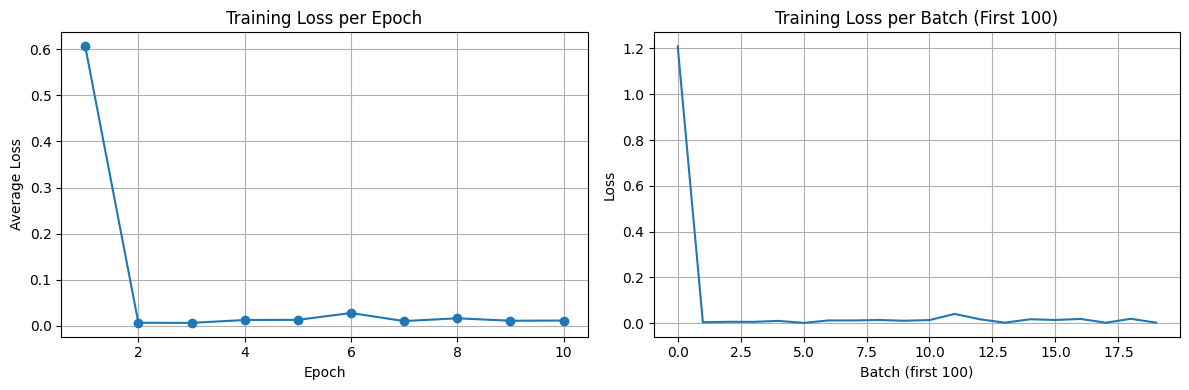

Plotted training history with 20 total batches


In [53]:
# 訓練履歴の可視化
plt.figure(figsize=(12, 4))

# エポックごとの平均損失
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['avg_loss'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)

# 全バッチの損失（最初の100バッチのみ表示）
plt.subplot(1, 2, 2)
plt.plot(history['loss'][:100])
plt.xlabel('Batch (first 100)')
plt.ylabel('Loss')
plt.title('Training Loss per Batch (First 100)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Plotted training history with {len(history['loss'])} total batches")

In [58]:
class TestProteinDataset(Dataset):
    """
    テストデータ用のデータセット（ラベルなし）
    """
    def __init__(
        self, 
        protein_emb_dict: Dict[Tuple[str, str], np.ndarray]
    ):
        """
        Parameters
        ----------
        protein_emb_dict : Dict[Tuple[str, str], np.ndarray]
            {(protein_id, taxon_id): embedding} 形式の辞書
        """
        # 辞書をリストに変換（順序を固定）
        self.protein_ids = list(protein_emb_dict.keys())
        self.embeddings = [protein_emb_dict[pid] for pid in self.protein_ids]
        
        # Tensorに変換
        self.X = torch.from_numpy(np.stack(self.embeddings, axis=0)).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'x': self.X[idx],                    # (protein_emb_dim,)
            'protein_id': self.protein_ids[idx]  # (protein_id, taxon_id)
        }


def test_collate_fn(batch):
    """
    テストデータ用のカスタムcollate_fn
    protein_idがタプルなので、デフォルトのcollate_fnでは処理できない
    """
    x_list = [item['x'] for item in batch]
    protein_ids = [item['protein_id'] for item in batch]
    
    return {
        'x': torch.stack(x_list),
        'protein_id': protein_ids  # リストのまま返す
    }


def create_test_loader(
    protein_emb_dict: Dict[Tuple[str, str], np.ndarray],
    batch_size: int = 16
) -> DataLoader:
    """
    テストデータのDataLoaderを作成する関数
    
    Parameters
    ----------
    protein_emb_dict : Dict[Tuple[str, str], np.ndarray]
        テストタンパク質の埋め込み辞書
    batch_size : int
        バッチサイズ
        
    Returns
    -------
    DataLoader
        テストデータのDataLoader
    """
    test_dataset = TestProteinDataset(protein_emb_dict)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # テストデータはシャッフルしない
        num_workers=0,
        collate_fn=test_collate_fn  # カスタムcollate_fnを使用
    )
    
    print(f"Test DataLoader created:")
    print(f"  Number of samples: {len(test_dataset)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Number of batches: {len(test_loader)}")
    
    return test_loader

In [59]:
# テストデータのDataLoaderを作成
# NOTE: 現時点ではmini_emb_dictをテストデータとして使用
# 本番では test_emb_dict を使用する

print("=" * 60)
print("Creating test DataLoader")
print("=" * 60)

test_loader = create_test_loader(
    protein_emb_dict=mini_emb_dict,  # TODO: 本番では test_emb_dict に置き換え
    batch_size=BATCH_SIZE
)

print()

Creating test DataLoader
Test DataLoader created:
  Number of samples: 17
  Batch size: 16
  Number of batches: 2



In [60]:
def predict(
    model: nn.Module,
    test_loader: DataLoader,
    device: torch.device,
    top_k: int = 100
) -> Dict[Tuple[str, str], List[Tuple[str, float]]]:
    """
    テストデータに対して推論を実行する関数
    
    Parameters
    ----------
    model : nn.Module
        訓練済みモデル
    test_loader : DataLoader
        テストデータのDataLoader
    device : torch.device
        使用するデバイス
    top_k : int
        各タンパク質に対して予測する上位K個のGO term
        
    Returns
    -------
    predictions : Dict[Tuple[str, str], List[Tuple[str, float]]]
        {(protein_id, taxon_id): [(go_id, score), ...]} 形式の予測結果
    """
    model.eval()
    predictions = {}
    
    print(f"Starting inference...")
    print(f"  Device: {device}")
    print(f"  Top-K predictions per protein: {top_k}")
    print(f"  Number of batches: {len(test_loader)}")
    print()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            # データをデバイスに移動
            x_batch = batch['x'].to(device)  # (B, protein_emb_dim)
            protein_ids = batch['protein_id']  # タプルのリスト
            
            # Forward pass
            probs = model.predict_proba(x_batch)  # (B, num_go)
            
            # 各サンプルについて上位K個のGO termを取得
            for i in range(len(protein_ids)):
                # 確率の高い順にソート
                scores = probs[i].cpu().numpy()
                top_indices = np.argsort(scores)[::-1][:top_k]
                
                # (GO ID, スコア) のリストを作成
                protein_id = protein_ids[i]
                predictions[protein_id] = [
                    (go_id_list[idx], float(scores[idx]))
                    for idx in top_indices
                ]
            
            # 進捗表示
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(test_loader):
                print(f"Processed batch [{batch_idx+1}/{len(test_loader)}]")
    
    print(f"\nInference completed!")
    print(f"  Total proteins predicted: {len(predictions)}")
    
    return predictions

In [61]:
# 推論を実行
print("=" * 60)
print("Running inference on test data")
print("=" * 60)

predictions = predict(
    model=joint_model,
    test_loader=test_loader,
    device=device,
    top_k=100  # 各タンパク質に対して上位100個のGO termを予測
)

# 予測結果のサンプル表示
print("\n" + "=" * 60)
print("Sample predictions")
print("=" * 60)
sample_protein_id = list(predictions.keys())[0]
sample_preds = predictions[sample_protein_id]
print(f"Protein: {sample_protein_id}")
print(f"Top 5 predicted GO terms:")
for i, (go_id, score) in enumerate(sample_preds[:5], 1):
    go_name = terms.get(go_id, {}).get('name', 'Unknown')
    print(f"  {i}. {go_id}: {score:.4f} ({go_name})")

Running inference on test data
Starting inference...
  Device: mps
  Top-K predictions per protein: 100
  Number of batches: 2

Processed batch [2/2]

Inference completed!
  Total proteins predicted: 17

Sample predictions
Protein: ('A0A0C5B5G6', '9606')
Top 5 predicted GO terms:
  1. GO:0097707: 0.0000 (ferroptosis)
  2. GO:0097504: 0.0000 (Gemini of Cajal bodies)
  3. GO:0097598: 0.0000 (sperm cytoplasmic droplet)
  4. GO:0010319: 0.0000 (stromule)
  5. GO:0021559: 0.0000 (trigeminal nerve development)


In [62]:
def create_submission_file(
    predictions: Dict[Tuple[str, str], List[Tuple[str, float]]],
    output_path: str,
    add_text_descriptions: bool = False
) -> None:
    """
    予測結果から提出ファイルを作成する関数
    
    Parameters
    ----------
    predictions : Dict[Tuple[str, str], List[Tuple[str, float]]]
        {(protein_id, taxon_id): [(go_id, score), ...]} 形式の予測結果
    output_path : str
        出力ファイルパス
    add_text_descriptions : bool
        テキスト説明行を追加するかどうか
    """
    rows = []
    
    print(f"Creating submission file...")
    print(f"  Number of proteins: {len(predictions)}")
    
    for (protein_id, taxon_id), go_predictions in predictions.items():
        # GO term predictions
        for go_id, score in go_predictions:
            rows.append({
                'protein_id': protein_id,
                'kind_or_term': go_id,
                'score': f"{score:.6f}",
                'description': None
            })
        
        # Text descriptions (optional)
        if add_text_descriptions:
            # ダミーのテキスト説明を3つ追加
            # 実際にはLLMなどで生成する必要がある
            for i in range(3):
                rows.append({
                    'protein_id': protein_id,
                    'kind_or_term': 'Text',
                    'score': f"{0.5:.6f}",  # ダミースコア
                    'description': f"Predicted function description {i+1} for {protein_id}"
                })
    
    # DataFrameに変換
    submission_df = pd.DataFrame(rows)
    
    # TSVファイルとして保存
    submission_df.to_csv(
        output_path,
        sep='\t',
        index=False,
        header=False
    )
    
    print(f"Submission file saved to {output_path}")
    print(f"  Total rows: {len(submission_df)}")
    print(f"  GO term predictions: {len([r for r in rows if r['kind_or_term'] != 'Text'])}")
    if add_text_descriptions:
        print(f"  Text descriptions: {len([r for r in rows if r['kind_or_term'] == 'Text'])}")
    
    # サンプル表示
    print(f"\nFirst 10 rows of submission:")
    print(submission_df.head(10).to_string(index=False))

In [63]:
# 提出ファイルを作成
print("\n" + "=" * 60)
print("Creating submission file")
print("=" * 60)

submission_path = "../output/submission.tsv"

create_submission_file(
    predictions=predictions,
    output_path=submission_path,
    add_text_descriptions=False  # テキスト説明は今回は含めない
)

print("\n" + "=" * 60)
print("Inference and submission file creation completed!")
print("=" * 60)


Creating submission file
Creating submission file...
  Number of proteins: 17
Submission file saved to ../output/submission.tsv
  Total rows: 1700
  GO term predictions: 1700

First 10 rows of submission:
protein_id kind_or_term    score description
A0A0C5B5G6   GO:0097707 0.000000        None
A0A0C5B5G6   GO:0097504 0.000000        None
A0A0C5B5G6   GO:0097598 0.000000        None
A0A0C5B5G6   GO:0010319 0.000000        None
A0A0C5B5G6   GO:0021559 0.000000        None
A0A0C5B5G6   GO:1990005 0.000000        None
A0A0C5B5G6   GO:0110016 0.000000        None
A0A0C5B5G6   GO:0005726 0.000000        None
A0A0C5B5G6   GO:0140074 0.000000        None
A0A0C5B5G6   GO:0120174 0.000000        None

Inference and submission file creation completed!
